In [393]:
import numpy as np
import torch
import networkx as nx
import difflib
import matplotlib.pyplot as plt
import matplotlib
from math import *
import torchvision
from torchvision import datasets, models, transforms
import copy

%config InlineBackend.figure_format = 'retina'

In [272]:
N = 100
k = 10
R = 10
epochs = int(1e4)

def y_seq_ones(comb_on, M):
    return np.random.choice(np.arange(M), size= comb_on, replace = False)
# Create input data
x_np = np.array([[1 if i ==j else 0 for i in range(N)] for j in range(N)])
x = torch.tensor(x_np).float()

In [375]:
# Train M = 20 network

M = 20
learning_rate = 1
# Creat output data for M = 20
y_ones_all = [y_seq_ones(k, M) for i in range(N)]
y_np = np.array([tuple([1 if i in y_ones_all[j] else 0 for i in range(M)]) for j in range(N)])
y = torch.tensor(y_np).float()

# Initialize network
model = torch.nn.Sequential(
  torch.nn.Linear(N, R),
  torch.nn.Sigmoid(),
  torch.nn.Linear(R,M),
  torch.nn.Sigmoid())
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, momentum=0.9)
# Train network
for t in range(epochs):
    # Run the forward pass
    y_pred = model(x)
    # Calculate the loss
    loss = loss_fn(y_pred, y)
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights using SGD
    optimizer.step()

# Calculate behaviors learned
per = 0.99
behaviourA = 0
y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
for j in range(len(y)):
    s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
    if s.ratio() > per:
        behaviourA += 1

In [376]:
# Extract M = 20 network parameters
trained_parameters = []
for param in model.named_parameters():
    trained_parameters.append(param[1].data.numpy())
w1 = trained_parameters[0]
b1 = trained_parameters[1]
w2 = trained_parameters[2]
b2 = trained_parameters[3]

In [377]:
# Create network for M = 40

# Fix encoder weights from M = 20
for param in model.parameters():
    param.requires_grad = False

# Remove the last M = 20 layer 
removed = list(model.children())[:-2]
model= torch.nn.Sequential(*removed)

M = 40
learning_rate = 60
# Add new M = 40 layer (Parameters of newly constructed modules have requires_grad=True by default)
model = torch.nn.Sequential(*list(model.children()), torch.nn.Linear(R,M), torch.nn.Sigmoid())
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, momentum=0.9)

In [378]:
# Creat M = 40 output data
y_ones_all = [y_seq_ones(k, M) for i in range(N)]
y_np = np.array([tuple([1 if i in y_ones_all[j] else 0 for i in range(M)]) for j in range(N)])
y = torch.tensor(y_np).float()

In [379]:
# Train M = 40 network
for t in range(epochs):
    # Run the forward pass
    y_pred = model(x)
    # Calculate the loss
    loss = loss_fn(y_pred, y)
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights using SGD
    optimizer.step()

# Calculate behaviors learned
per = 0.99
behaviourB = 0
y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
for j in range(len(y)):
    s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
    if s.ratio() > per:
        behaviourB += 1

In [250]:
# Extract M = 40 network parameters
trained_parameters = []
for param in model.named_parameters():
    trained_parameters.append(param[1].data.numpy())
w1_B = trained_parameters[0]
b1_B = trained_parameters[1]
w2_B = trained_parameters[2]
b2_B = trained_parameters[3]

# Compare learning curves

Calculate learning curves as a function of $R$ for
- $M = 20$ 
- $M = 40$ random initialization
- $M = 40$ initialize encoder weights with $M = 20$ weights
- $M = 40$ initialize and fix encoder weights with $M = 20$ weights

In [385]:
beh_1 = []
beh_2 = []
beh_3 = []
beh_4 = []
epochs = int(1e4)

# Create output for M = 20 and M = 40

M = 20
y_ones_all = [y_seq_ones(k, M) for i in range(N)]
y_np = np.array([tuple([1 if i in y_ones_all[j] else 0 for i in range(M)]) for j in range(N)])
y20 = torch.tensor(y_np).float()
M = 40
y_ones_all = [y_seq_ones(k, M) for i in range(N)]
y_np = np.array([tuple([1 if i in y_ones_all[j] else 0 for i in range(M)]) for j in range(N)])
y40 = torch.tensor(y_np).float()

# Train networks and get learning curves

for R_ind, R in enumerate(np.arange(1, 10)*2):
    R = int(R)
    print(R_ind)
    
    # M = 20
    
    M = 20
    y = y20
    learning_rate = 1
    model = torch.nn.Sequential(
        torch.nn.Linear(N, R),
        torch.nn.Sigmoid(),
        torch.nn.Linear(R,M),
        torch.nn.Sigmoid())
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=learning_rate, momentum=0.9)
    for t in range(epochs):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    per = 0.99
    behaviour = 0
    behaviours_learnt = []
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    for j in range(len(y)):
        s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
        if s.ratio() > per:
            behaviour += 1
    beh_1.append(behaviour/N)

    # M = 40 initialize and fix encoder weights with M = 20 weights
    
    M = 40
    y = y40
    learning_rate = 50
    
    for param in model.parameters():
        param.requires_grad = False

    removed = list(model.children())[:-2]
    model= torch.nn.Sequential(*removed)
    model = torch.nn.Sequential(*list(model.children()), torch.nn.Linear(R,M), torch.nn.Sigmoid())
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=learning_rate, momentum=0.9)
    for t in range(epochs):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    per = 0.99
    behaviour = 0
    behaviours_learnt = []
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    for j in range(len(y)):
        s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
        if s.ratio() > per:
            behaviour += 1
    beh_4.append(behaviour/N)
    
    # M = 40 initialize encoder weights with M = 20 weights
    
    for param in model.parameters():
        param.requires_grad = True

    removed = list(model.children())[:-2]
    model= torch.nn.Sequential(*removed)
    model = torch.nn.Sequential(*list(model.children()), torch.nn.Linear(R,M), torch.nn.Sigmoid())
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=learning_rate, momentum=0.9)
    for t in range(epochs):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    per = 0.99
    behaviour = 0
    behaviours_learnt = []
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    for j in range(len(y)):
        s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
        if s.ratio() > per:
            behaviour += 1
    beh_2.append(behaviour/N)
    
    # M = 40 random initialization
    
    model2 = torch.nn.Sequential(
        torch.nn.Linear(N, R),
        torch.nn.Sigmoid(),
        torch.nn.Linear(R,M),
        torch.nn.Sigmoid())
    loss_fn2 = torch.nn.MSELoss()
    optimizer2 = torch.optim.SGD(model2.parameters(), 
                                lr=learning_rate, momentum=0.9)
    for t in range(epochs):
        y_pred = model2(x)
        loss2 = loss_fn2(y_pred, y)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

    per = 0.99
    behaviour = 0
    behaviours_learnt = []
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    for j in range(len(y)):
        s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
        if s.ratio() > per:
            behaviour += 1
    beh_3.append(behaviour/N)

0
1
2
3
4
5
6
7
8


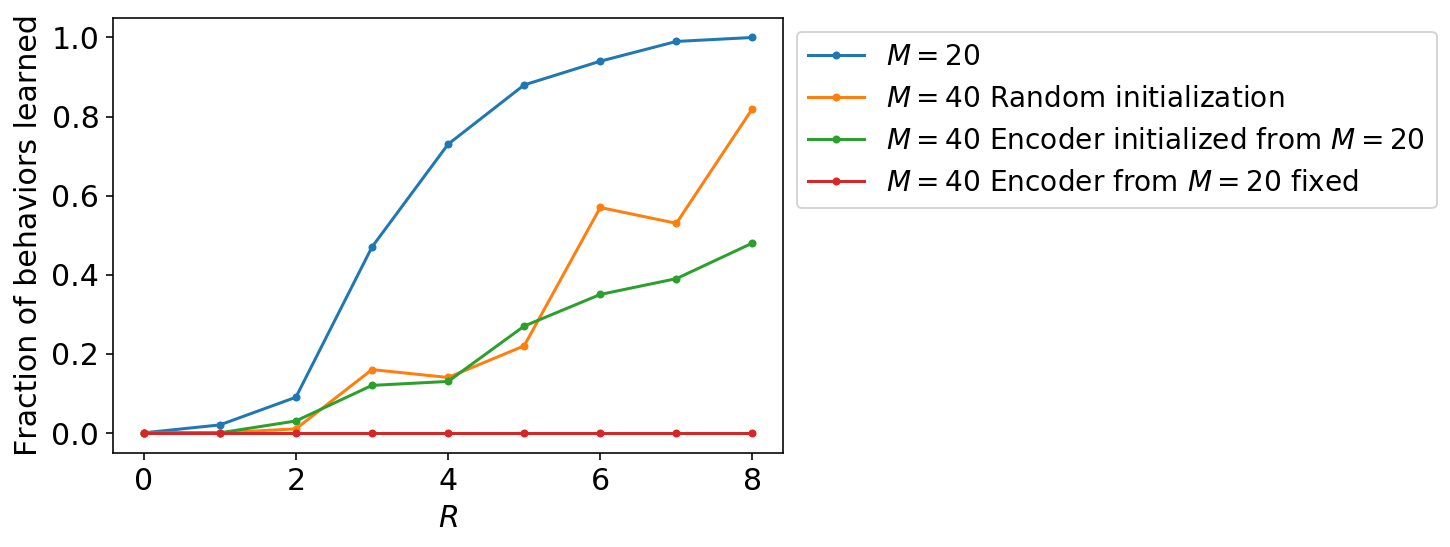

In [396]:
plt.figure()
plt.plot(beh_1, '.-', label = '$M = 20$')
plt.plot(beh_3, '.-', label = '$M = 40$ Random initialization')
plt.plot(beh_2, '.-', label = '$M = 40$ Encoder initialized from $M = 20$')
plt.plot(beh_4, '.-', label = '$M = 40$ Encoder from $M = 20$ fixed ')

plt.xlabel('$R$', fontsize=15)
plt.ylabel('Fraction of behaviors learned', fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(bbox_to_anchor = (1,1), fontsize = 14)
plt.show()

### Defining the model for Pytorch

* We have one hidden layer with sigmoid activation in addition to the input and output layers. We want to binarize the output so there is another sigmoid activation on it.
* Defining the optimization routine. Here we use stochastic gradient descent with momentum = 0.9. This helps move between local minima in order to reach the global minimum.

In [50]:
beh_1_all = []
for it_ind in range(1):
    learning_rate = 2e0

    beh_learnt_all = []
    for R_ind, R in enumerate(np.arange(20, 50)[:]):
            R = int(R)
            print(R_ind)
        for k_ind, M in enumerate(Ms):
            print(M)
            beh_k = []
            M = int(Ms[k_ind])
            y_ones_all = [y_seq_ones(k, M) for i in range(N)]
            y_np = np.array([tuple([1 if i in y_ones_all[j] else 0 for i in range(M)]) for j in range(N)])
            y = torch.tensor(y_np).float()
            epochs = int(1.5e5)
        
            model = torch.nn.Sequential(
              torch.nn.Linear(N, R),
              torch.nn.Sigmoid(),
              torch.nn.Linear(R,M),
              torch.nn.Sigmoid())
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), 
                                        lr=learning_rate, momentum=0.9)
            for t in range(epochs):
                # Run the forward pass
                y_pred = model(x)
                # Calculate the loss
                loss = loss_fn(y_pred, y)
                # Zero the gradients before running the backward pass.
                optimizer.zero_grad()
                # Backward pass
                loss.backward()
                # Update weights using SGD
                optimizer.step()
            
            per = 0.99
            threshold = 0.5
            behaviour = 0
            behaviours_learnt = []
            y_pred_binary = np.abs(np.round(y_pred.data.numpy()+0.5-threshold))
            for j in range(len(y)):
                s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
                if s.ratio() > per:
                    behaviour += 1
            beh_k.append(behaviour/N)
        beh_learnt_all.append(beh_k)
    beh_1_all.append(beh_learnt_all)

20.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
26.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
32.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
39.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
45.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
51.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
57.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
63.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
70.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
76.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
82.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
88.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
2

KeyboardInterrupt: 

(0, 10)

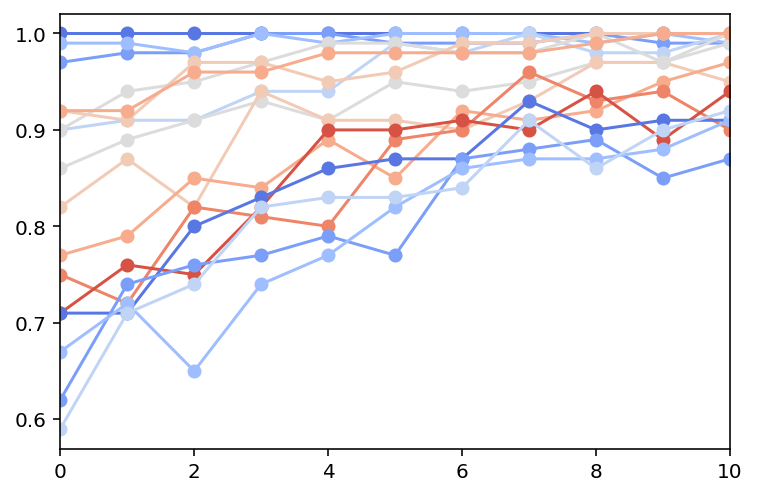

In [54]:
for i in range(len(beh_learnt_all)):
    plt.plot(beh_learnt_all[i], 'o-')
plt.xlim([0, 10])

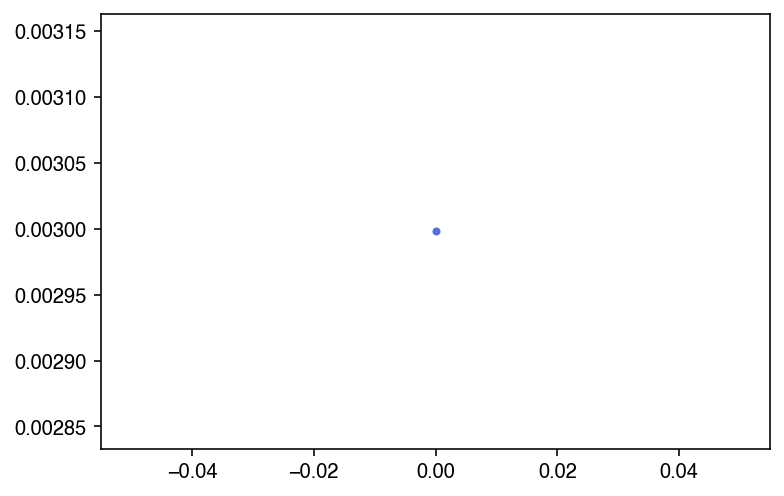

In [180]:
plt.plot(loss.detach().numpy(), '.-')

In [164]:
for beh in beh_1_all[0][1:]:
    beh.insert(0,0)

In [160]:
beh_1_all[0].insert(0,0)

In [146]:
beh_R_k_10_all_avg = []
beh_R_k_10_all_std = []

for beh_ind in range(len(Ms)):
    print(beh_ind)
    b_all = np.array([b_set[beh_ind] for b_set in beh_1_all[:]])
    b_avg = [np.mean(b_ele) for b_ele in b_all.T]
    b_std = [np.std(b_ele) for b_ele in b_all.T]
    beh_R_k_10_all_avg.append(b_avg)
    beh_R_k_10_all_std.append(b_std)

0
1
2
3
4
5
6
7
8
9


In [147]:
beh_R_k_10_all = []
for beh in beh_1_all:
    beh_R_k_10_all.append(beh)

In [33]:
%store -r beh_R_k_10_all
%store -r beh_R_k_10_all_avg
%store -r beh_R_k_10_all_std

In [34]:
import seaborn as sns
sns.set_palette("coolwarm", 9)

%config InlineBackend.figure_format = 'retina'

In [6]:
for km_ind in range(len(Ms)):
    beh_R_k_10_all_std[km_ind].insert(0, 0)
    beh_R_k_10_all_avg[km_ind].insert(0, 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


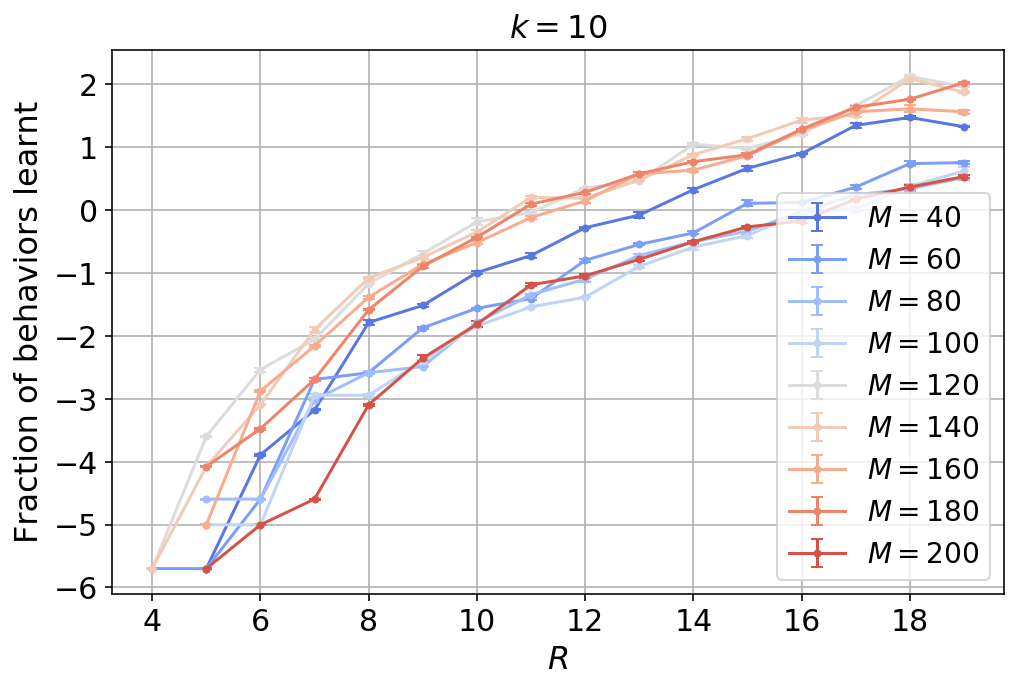

In [49]:
plt.figure(figsize=(8,5))
for km_ind in range(1, len(Ms)):
    plt.errorbar(np.arange(2, 20)[:], -np.log(1/np.array(beh_R_k_10_all_avg[km_ind][2:])-1), 
             yerr = beh_R_k_10_all_std[km_ind][2:], capsize=3, label = '$M = {}$'.format(int(Ms[km_ind])), 
                 marker ='.')
# for i in range(len(Ms)-1):
#     plt.plot(beh_1_all[0][i+1], 'o-')
plt.xlabel('$R$', fontsize=16)
plt.ylabel('Fraction of behaviors learnt', fontsize=16)
plt.tick_params(labelsize=15)
plt.legend(fontsize=14)
plt.title('$k = 10$', fontsize=16)
plt.grid(True)
# plt.xlim([0, 20])
# plt.ylim([-0., 0.2])
# plt.ylim([0, 1.1])
# plt.savefig('k10.pdf')
plt.show()

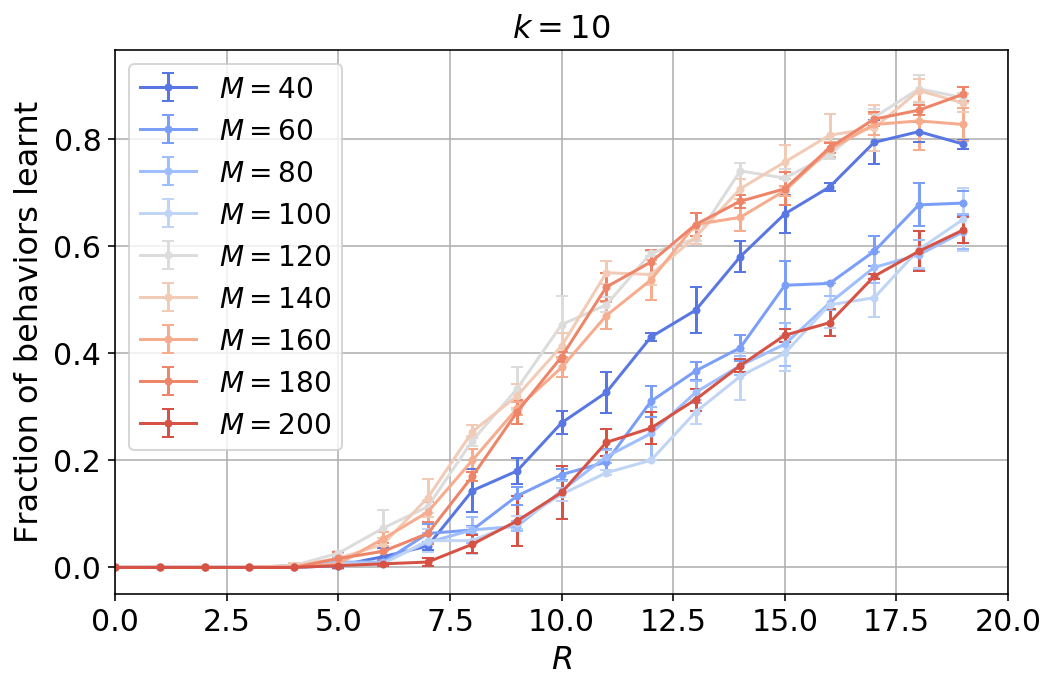

In [20]:
plt.figure(figsize=(8,5))
for km_ind in range(1, len(Ms)):
    plt.errorbar(np.arange(0, 20)[:], np.array(beh_R_k_10_all_avg[km_ind]), 
             yerr = beh_R_k_10_all_std[km_ind], capsize=3, label = '$M = {}$'.format(int(Ms[km_ind])), 
                 marker ='.')
# for i in range(len(Ms)-1):
#     plt.plot(beh_1_all[0][i+1], 'o-')
plt.xlabel('$R$', fontsize=16)
plt.ylabel('Fraction of behaviors learnt', fontsize=16)
plt.tick_params(labelsize=15)
plt.legend(fontsize=14)
plt.title('$k = 10$', fontsize=16)
plt.grid(True)
plt.xlim([0, 20])
# plt.ylim([-0., 0.2])
# plt.ylim([0, 1.1])
# plt.savefig('k10.pdf')
plt.show()